In [23]:
import numpy as np
import hydra
import torch
import itertools
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from pytorch_lightning import (
    LightningDataModule,
    LightningModule,
    seed_everything,
)

from utils import *
from multimodal_contrastive.utils import utils

In [2]:
OmegaConf.register_new_resolver("sum", lambda input_list: np.sum(input_list))
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# Load config for CLIP model
config_name = "puma_smg_gmc"
configs_path = "../../configs"

with hydra.initialize(version_base=None, config_path=configs_path):
    cfg = hydra.compose(config_name=config_name)

cfg

{'datamodule': {'_target_': 'multimodal_contrastive.data.datamodule.MultiInput_DataModule', 'dataset': {'_target_': 'multimodal_contrastive.data.dataset.H5DatasetPUMA', 'data': '/home/mila/s/stephen.lu/gfn_gene/multimodal_contrastive/datasets/puma_by_mod_20240103.h5', 'labels': None, 'mods': ['struct', 'morph', 'ge'], 'joint_as_input': True}, 'batch_size': 128, 'num_workers': 8, 'split_sizes': [0.8, 0.1, 0.1], 'split_type': 'random'}, 'model': {'_target_': 'multimodal_contrastive.networks.models.GMC_PL', 'loss_name': 'gmc', 'temperature': 0.4, 'lr': 2e-06, 'dim': 1024, 'morph_input_dim': 1746, 'encode_dim': '${.dim}', 'proj_dim': '${.dim}', 'latent_dim': '${.dim}', 'hid_dim': '${.dim}', 'encoders_mod': {'struct': {'_target_': 'multimodal_contrastive.networks.components.GNEpropGIN', 'in_channels': 133, 'edge_dim': 12, 'hidden_channels': '${...encode_dim}', 'ffn_hidden_channels': None, 'num_layers': 5, 'out_channels': 1, 'num_readout_layers': 2, 'mol_features_size': 0.0, 'dropout': 0.0, 

In [4]:
# set seed for random number generators in pytorch, numpy and python.random
# and especially for generating the same data splits for the test set
if cfg.get("seed"):
    seed_everything(cfg.seed, workers=True)

In [5]:
# Load test data split
datamodule: LightningDataModule = hydra.utils.instantiate(cfg.datamodule)
datamodule.setup("test")

train_loader = datamodule.train_dataloader()
test_loader = datamodule.infer_dataloader()

/home/mila/s/stephen.lu/miniconda3/envs/mmc_sim/lib/python3.10/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


Train on samples from random.
Train on 13582 samples.
Validate on 1698 samples.
Test on 1698 samples.


/home/mila/s/stephen.lu/miniconda3/envs/mmc_sim/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [6]:
# Load model from checkpoint
ckpt_path = "../../runs/3qr54w6w/checkpoints/epoch=101-step=10812.ckpt"
model: LightningModule = utils.instantiate_model(cfg)
model = model.load_from_checkpoint(ckpt_path, map_location=device)
model = model.eval()

INFO:root:Instantiating torch.nn.module JointEncoder
INFO:root:Instantiating lightning model <multimodal_contrastive.networks.models.GMC_PL>
/home/mila/s/stephen.lu/miniconda3/envs/mmc_sim/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:196: UserWarning: Attribute 'encoder_joint' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_joint'])`.
  rank_zero_warn(
/home/mila/s/stephen.lu/miniconda3/envs/mmc_sim/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:196: UserWarning: Attribute 'common_encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['common_encoder'])`.
  rank_zero_warn(


In [7]:
# Set which loader to use
loader = test_loader

# Peek at the first example in the loaded set
example = next(iter(loader))
inputs = example["inputs"]
struct, ge, morph = inputs["struct"], inputs["ge"], inputs["morph"]

print(struct)
print(ge.shape)

DataBatch(x=[4224, 133], edge_index=[2, 9108], edge_attr=[9108, 12], mols=[128], batch=[4224], ptr=[129])
torch.Size([128, 977])


In [8]:
# Get latent representations for all test examples
representations, mols = model.compute_representation_dataloader(
    loader,
    device=device,
    return_mol=True
)

100%|██████████| 14/14 [00:06<00:00,  2.02it/s]


In [9]:
# Save representations to disk
save = False
if save:
    save_representations(mols, representations, "representations.npz")

In [10]:
# If dataset is too large, randomly subset to cutoff molecules
p_mols, p_representations = random_subset(mols, representations, cutoff=3000)

In [11]:
# Use rdkit to get Morgan fingerprints for each molecule in mols
mol_fps = get_molecular_fingerprints(p_mols, fp_type="morgan", radius=3, nbits=2048)
tanimoto_sim = get_molecular_similarity(mol_fps, "tanimoto")

100%|██████████| 1698/1698 [00:09<00:00, 185.35it/s]


In [ ]:
# Get the raw gene expression vectors from the dataloader
mods = unroll_dataloader(test_loader)
ge = mods['ge']

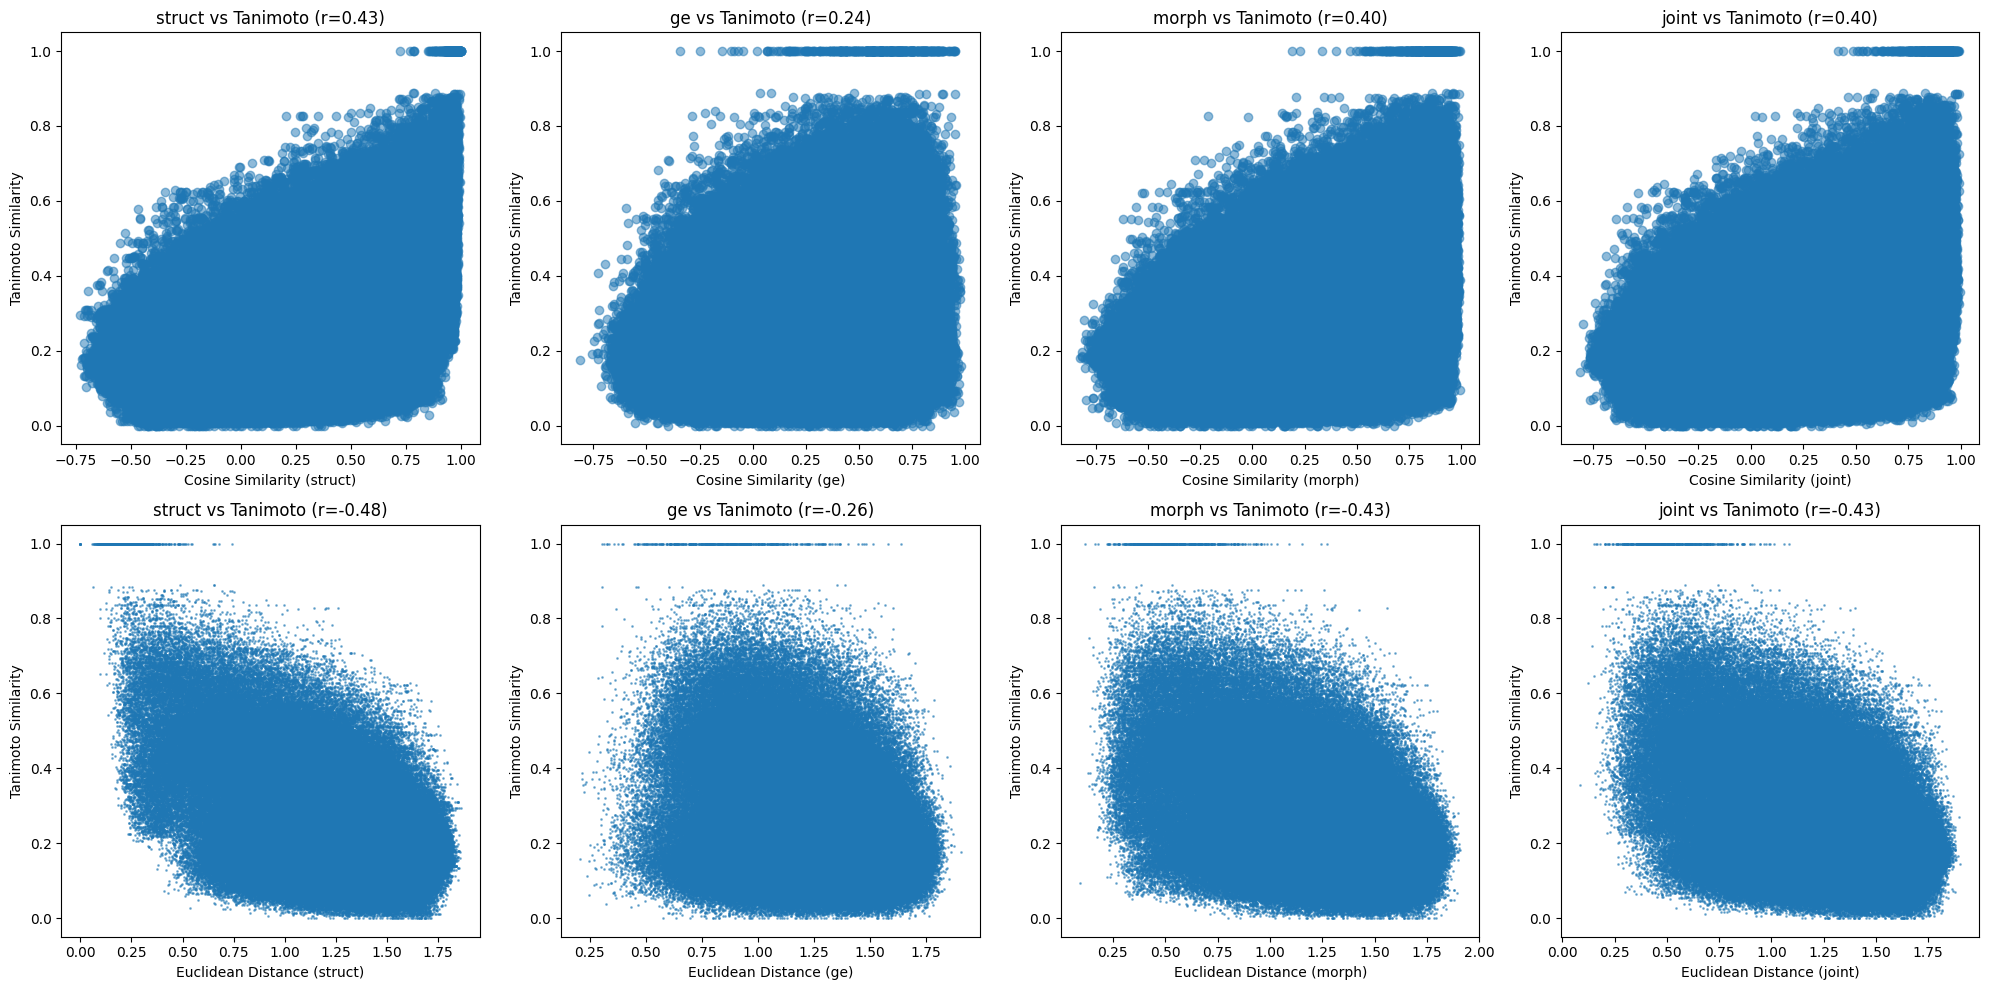

In [17]:
# Single modality latent distance versus tanimoto similarity
mods_x = ['struct', 'ge', 'morph', 'joint']
mods_y = tanimoto_sim

fig, ax = plt.subplots(2, 4, figsize=(20, 10))

for idx, mod_x in enumerate(mods_x):
    x = get_pairwise_similarity(
        p_representations[mod_x],
        p_representations[mod_x],
        metric="cosine"
    )
    x, y = get_values_from_dist_mat(x, mods_y, keep_diag=False)
    corr = np.corrcoef(x, y)

    ax[0, idx].scatter(x, y, alpha=0.5)
    ax[0, idx].set_xlabel(f"Cosine Similarity ({mod_x})")
    ax[0, idx].set_ylabel("Tanimoto Similarity")
    ax[0, idx].set_title(f"{mod_x} vs Tanimoto (r={corr[0, 1]:.2f})")

for idx, mod_x in enumerate(mods_x):
    x = get_pairwise_similarity(
        p_representations[mod_x],
        p_representations[mod_x],
        metric="euclidean"
    )
    x, y = get_values_from_dist_mat(x, mods_y, keep_diag=False)
    corr = np.corrcoef(x, y)
    
    ax[1, idx].scatter(x, y, alpha=0.5, s=1)
    ax[1, idx].set_xlabel(f"Euclidean Distance ({mod_x})")
    ax[1, idx].set_ylabel("Tanimoto Similarity")
    ax[1, idx].set_title(f"{mod_x} vs Tanimoto (r={corr[0, 1]:.2f})")

plt.tight_layout()
plt.savefig("single_modality_vs_tanimoto.png")
plt.show()

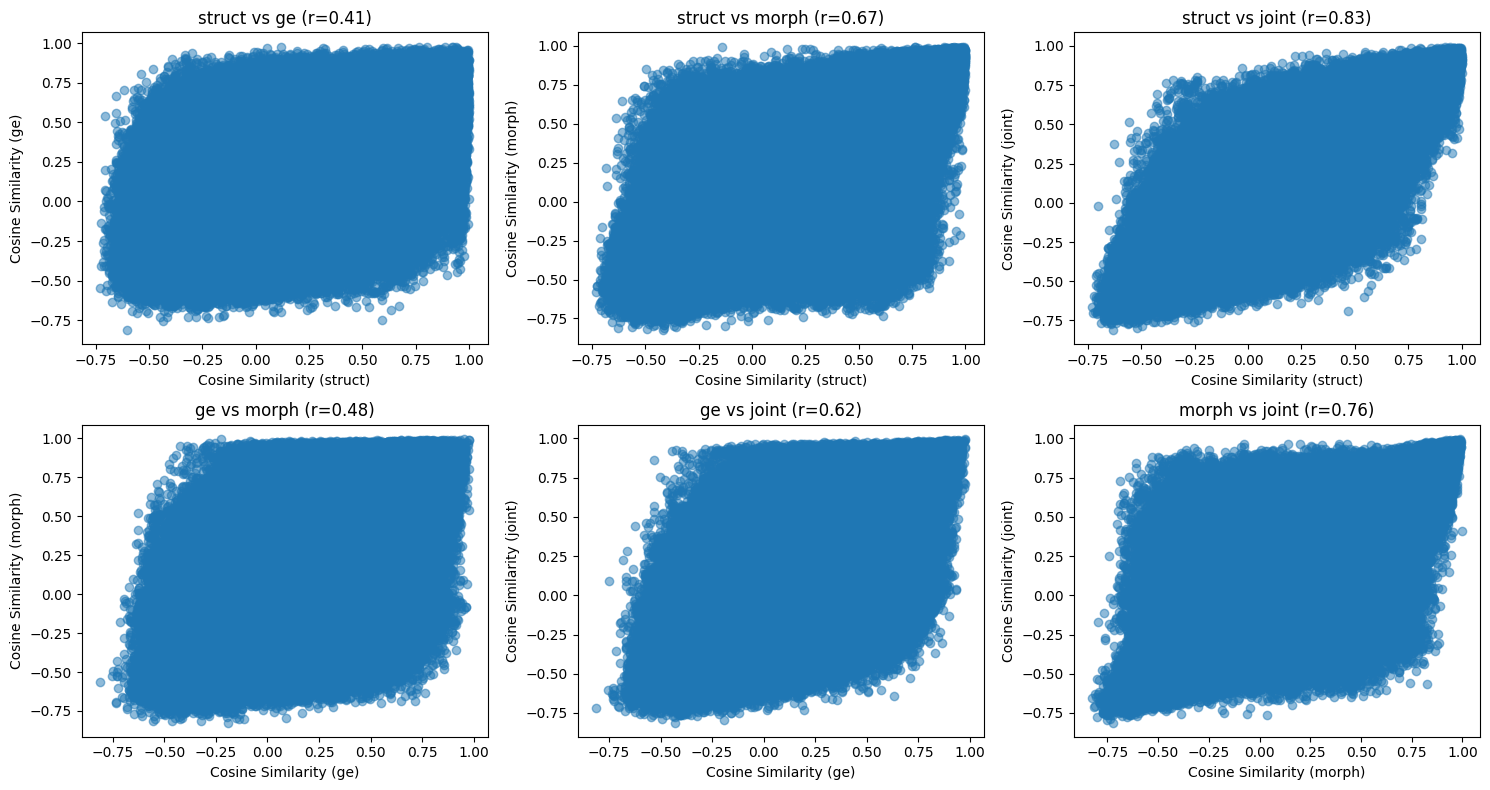

In [20]:
# plotting different modalities of the same samples against each other
mods = ['struct', 'ge', 'morph', 'joint']

fig, ax = plt.subplots(2, 3, figsize=(15, 8))
ctr = 0

for idx in range(len(mods)):
    for idy in range(idx+1, len(mods)):
        x = get_pairwise_similarity(
            p_representations[mods[idx]],
            p_representations[mods[idx]],
            metric="cosine"
        )
        y = get_pairwise_similarity(
            p_representations[mods[idy]],
            p_representations[mods[idy]],
            metric="cosine"
        )
        x, y = get_values_from_dist_mat(x, y, keep_diag=False)
        corr = np.corrcoef(x, y)
        
        ax_idx = 1 if ctr >= 3 else 0

        ax[ax_idx, ctr%3].scatter(x, y, alpha=0.5)
        ax[ax_idx, ctr%3].set_xlabel(f"Cosine Similarity ({mods[idx]})")
        ax[ax_idx, ctr%3].set_ylabel(f"Cosine Similarity ({mods[idy]})")
        ax[ax_idx, ctr%3].set_title(f"{mods[idx]} vs {mods[idy]} (r={corr[0, 1]:.2f})")
        ctr += 1
        
plt.tight_layout()
plt.savefig("single_modality_vs_single_modality.png")
plt.show()

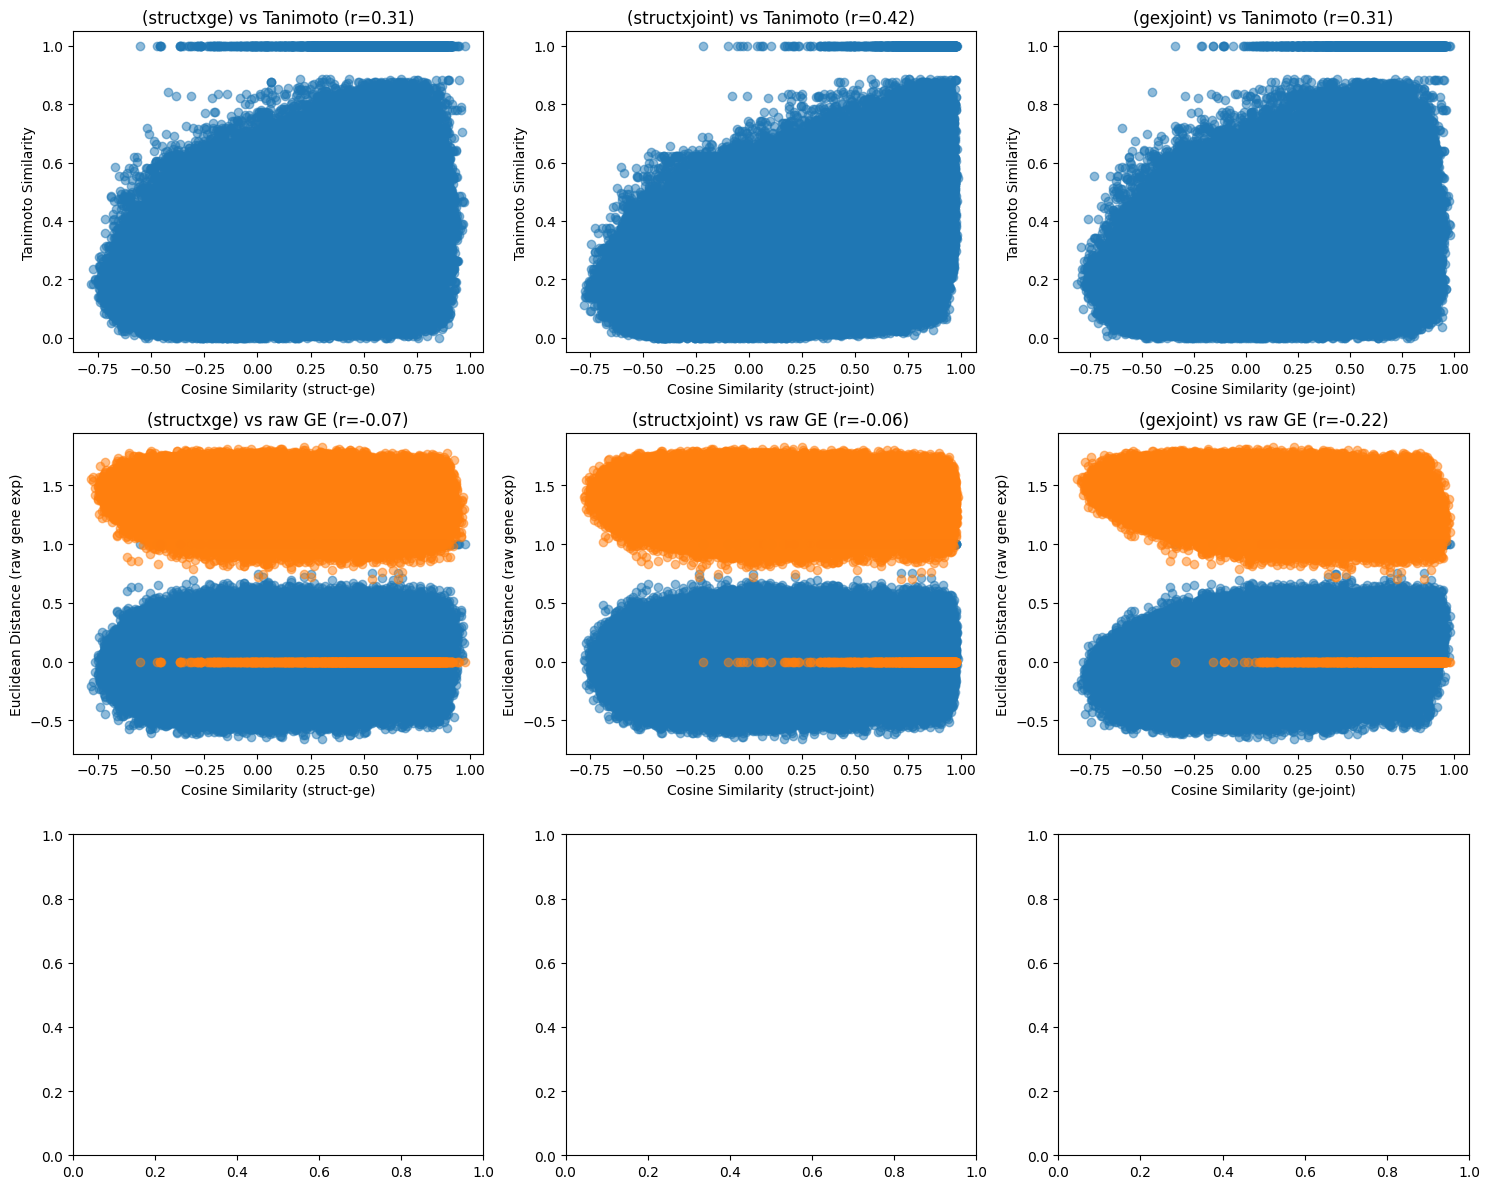

In [25]:
# plotting cross-modality latent similarity versus raw data domain similarity
mods_x = ['struct', 'ge', 'joint']
mods_y = {
    'tanimoto': tanimoto_sim,
    'gene exp': ge,
}

fig, ax = plt.subplots(3, 3, figsize=(15, 12))

for idx, (mod_a, mod_b) in enumerate(itertools.combinations(mods_x, 2)):
    x = get_pairwise_similarity(
        p_representations[mod_a],
        p_representations[mod_b],
        metric="cosine"
    )
    x, y = get_values_from_dist_mat(x, tanimoto_sim, keep_diag=True)
    corr = np.corrcoef(x, y)

    ax[0, idx].scatter(x, y, alpha=0.5)
    ax[0, idx].set_xlabel(f"Cosine Similarity ({mod_a}-{mod_b})")
    ax[0, idx].set_ylabel("Tanimoto Similarity")
    ax[0, idx].set_title(f"({mod_a}x{mod_b}) vs Tanimoto (r={corr[0, 1]:.2f})")
    
for idx, (mod_a, mod_b) in enumerate(itertools.combinations(mods_x, 2)):
    x = get_pairwise_similarity(
        p_representations[mod_a],
        p_representations[mod_b],
        metric="cosine"
    )
    y = get_pairwise_similarity(ge, ge, metric="cosine")
    x, y = get_values_from_dist_mat(x, y, keep_diag=True)
    corr = np.corrcoef(x, y)

    ax[1, idx].scatter(x, y, alpha=0.5)
    ax[1, idx].set_xlabel(f"Cosine Similarity ({mod_a}-{mod_b})")
    ax[1, idx].set_ylabel("Cosine Similarity (raw gene exp)")
    ax[1, idx].set_title(f"({mod_a}x{mod_b}) vs raw GE (r={corr[0, 1]:.2f})")
    
for idx, (mod_a, mod_b) in enumerate(itertools.combinations(mods_x, 2)):
    x = get_pairwise_similarity(
        p_representations[mod_a],
        p_representations[mod_b],
        metric="cosine"
    )
    y = get_pairwise_similarity(ge, ge, metric="euclidean")
    x, y = get_values_from_dist_mat(x, y, keep_diag=True)
    corr = np.corrcoef(x, y)

    ax[2, idx].scatter(x, y, alpha=0.5)
    ax[2, idx].set_xlabel(f"Cosine Similarity ({mod_a}-{mod_b})")
    ax[2, idx].set_ylabel("Euclidean Distance (raw gene exp)")
    ax[2, idx].set_title(f"({mod_a}x{mod_b}) vs raw GE (r={corr[0, 1]:.2f})")
        
plt.tight_layout()
plt.savefig("cross_modality_vs_raw_sim.png")
plt.show()